# 1 Preparation

## What is the purpose of an activation function in NN in general?
The activation function decides what output the neuron should give in relation to its input values and weights.

## What’s the advantage of e.g. sigmoid over the step function (threshold function)?
The sigmoid function allows for a smoother activation rather than an on-off activation as seen in the step function. With this we can express uncertainty in our classifications.


## How does sigmoid look like (the formula as well as the graph)?

Formula:
$\sigma(x) = \frac{1}{1+e^{-x}}$

Graph

![Graph of the Simoid function](https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Sigmoid-function-2.svg/2000px-Sigmoid-function-2.svg.png)

Source: Wikipedia

## What is the derivative of sigmoid?

$\sigma(x)' = \sigma(x)(1 - \sigma(x))$

## Implementation of the Sigmoid function

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Derivative of Sigmoid function
def sigmoidprime(x):
    return (sigmoid(x)*(1-sigmoid(x)))

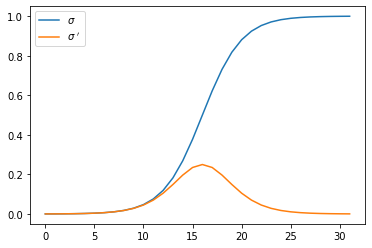

In [3]:
# Quick visualization to confirm the formula is correct

values = np.arange(-8,8, 0.5)
plt.plot(sigmoid(values))
plt.plot(sigmoidprime(values))
plt.legend(["$\sigma$", "$\sigma \ '$"])
plt.show()

# 3 Perceptron

### data set
We are training the network on logical gates (and, or, not and, not or, xor = exclusive or)

In [4]:
# These are the four possible input pairs of (x1,x2).
x = np.array([[0,0],[0,1],[1,0],[1,1]])

# These are possible labels form some logical gates.
t_and = np.array([0,0,0,1])
t_or = np.array([0,1,1,1])
t_nand = np.array([1,1,1,0])
t_nor = np.array([1,0,0,0])
t_xor = np.array([0,1,1,0])

Our multilayer-Perceptron will consist of single Perceptrons. So we need a class Perceptron. 

In [5]:
class Perceptron:

    def __init__(self, input_units):
        self.input_units = input_units
        #Initialize random weights and a random bias term
        self.weights = np.random.randn(input_units)
        self.bias = np.random.randn()
        #specify a learning rate of 1
        self.alpha = 1
        #the drive
        self.weighted_sum = 0
        self.input_data = 0
        
    def forward_step(self, input_data):
        """Weigh the input data according to weights and bias and return the activation of the neuron"""
        # 1. Calculate the drive. You can use @ as a matrix multiplication command.
        self.input_data = input_data
        self.weighted_sum =  self.weights @ input_data + self.bias 
        #returns the activation given by the activation function "sigmoid" applied on the drive
        return sigmoid(self.weighted_sum)
        
    def update(self, delta):
        """Updates bias and weights of the perceptron scaled by the learning rate alpha"""
        # We consider 1 as the "input" to the bias, so that we can treat it just like the other weights
        # if you are not familiar with this take a look at https://youtu.be/StDAe8HN9bU
        self.bias -= delta * self.alpha
        self.weights -= delta * self.alpha * self.input_data
        

Further, we will need a class MLP() that can perform a forward and backprop-step. Our MLP consists of one hidden layer with 4 perceptrons and 1 output neuron.
If you need more information on how forward and backprop-steps work take a look at https://studip.uni-osnabrueck.de/plugins.php/courseware/courseware?cid=b16f30cfd047652abb0b01a5d617f84f&selected=130456

In [6]:
class MLP:
    """Creates a multi-layer perceptron with 2 input neurons, 1 hidden layer with 4 perceptrons by default and 1 output layer"""
    def __init__(self, inputs=2, neurons_in_layer=4):
        # 1. create a list of perceptrons for our hidden layer
        self.perceptrons = np.array([Perceptron(inputs) for _ in range(neurons_in_layer)])
        # 2.create an output-perceptron
        self.output_neuron = Perceptron(neurons_in_layer)
        self.output = 0

    def forward_step(self, input_data):
        """Calculate the activation for the whole network"""
        # compute the activations for the hidden layer
        hidden_activation = np.array([perceptron.forward_step(input_data) for perceptron in self.perceptrons])
        # feed the output of the hidden layer to the output layer to compute the output
        # we need to reshape the array of the activation of the hidden layer
        self.output = self.output_neuron.forward_step(np.reshape(hidden_activation, newshape=(-1)))
                    
    def backprop_step(self, label):
        """Adjust the weights and bias of each neuron starting with the output neuron and then the hidden layer"""
        
        # Calculate adjustment for output layer
        delta_output = -(label - self.output) * sigmoidprime(self.output_neuron.weighted_sum)
        #update the output neuron
        self.output_neuron.update(delta_output)
        
        
        # Adjust the perceptrons in the hidden layer and calculate its error
        deltas_hidden = [delta_output * sigmoidprime(n.weighted_sum) * self.output_neuron.weights[i] for i,n in enumerate(self.perceptrons)]
        for i, perceptron in enumerate(self.perceptrons):
            perceptron.update(deltas_hidden[i])



# Training the network

Now we will train our network for 1000 epochs (One epoch is looping over each point in your dataset once). As a loss function for training we will use the squared error (t − y)2. This loss is the sigmoid output vs. the target.

In [7]:
def train(target, input_data, epochs=1000):
    """
    Wrapper function around the training process.
    Choose a logic gate as target, specify the input data
    and optionaly for how many epochs you want to train.
    After training, the function outputs a plot of the performance metrics.
    """
    # Initialize the network
    mlp = MLP()

    # Initialize lists to store steps and performance.
    steps = []
    accuracies = []
    losses = []

    # Train for x epochs
    for i in range(epochs):
        steps.append(i)
        loss=0
        accuracy=0
        
        #in each epoch 
        #np.random.choice generates a random sample from a given 1-D array (treats 4 as if a were np.arange(a))
        for index in np.random.choice(4,size=4,replace=False):
            # Select random sample with corresponding label
            sample = input_data[index]
            label = target[index]
            
            #training using the functions described above
            mlp.forward_step(sample)
            mlp.backprop_step(label)
            
            # Calculate squared error and accuracy
            # squared error: (t − y)^2
            loss += (label - mlp.output) ** 2 
            accuracy += int(np.abs(label - mlp.output)<0.5)

        losses.append(loss/4) # we divide through all the training examples            
        accuracies.append(accuracy/4) # we divide through all the training examples


    # Plot our performance metrics
    plot_network_performance(steps, losses, accuracies)
    


# Visualization

In [8]:
def plot_network_performance(steps, losses, accuracies):
    """Helper function to visualize the networks' performance metrics"""

    fig, axs = plt.subplots(2)
    fig.suptitle('Performance')
    # Plot for error
    axs[0].plot(steps, losses)
    axs[0].set(xlabel='Steps', ylabel='Error')
    # Plot for accuracy
    axs[1].plot(steps, accuracies)
    axs[1].set(xlabel='Steps', ylabel='Accuracy')

    plt.show()

# Training examples on the different logic gates

## AND-Gate

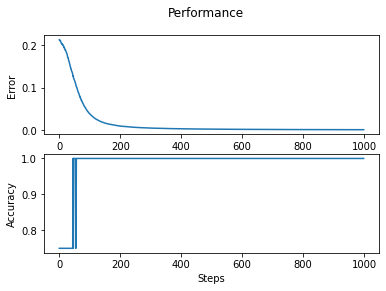

In [9]:
train(t_and, x)

## OR-Gate

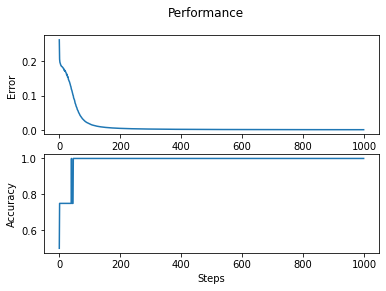

In [10]:
train(t_or, x)

## NAND-Gate

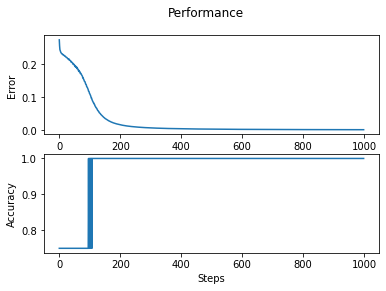

In [11]:
train(t_nand, x)

## NOR-Gate

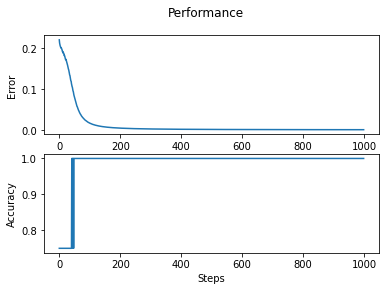

In [12]:
train(t_nor, x)

## XOR-Gate

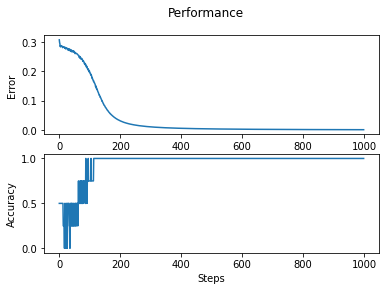

In [14]:
train(t_xor, x)